In [13]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from scipy.cluster.hierarchy import linkage, leaves_list
from tools.krx_client import KrxClient

In [6]:
today = datetime.datetime.today()
start_date = today - datetime.timedelta(days=150)

krx = KrxClient()
etf_data = krx.get_etf_data(
    start_date.strftime("%Y-%m-%d"), 
    today.strftime("%Y-%m-%d")
)

ETF 데이터 조회 완료: 49682개 레코드


In [7]:
col_lst = [
    "TRD_DD", "TDD_CLSPRC", "ACC_TRDVAL", 
    "MKTCAP", "ISU_ABBRV", "IDX_IND_NM",
]
pivot_df = etf_data[col_lst].pivot(
    index="TRD_DD", columns="ISU_ABBRV", values=["TDD_CLSPRC", "ACC_TRDVAL", "MKTCAP"]
)
pivot_df.index = pd.to_datetime(pivot_df.index)
pivot_df.sort_index(inplace=True)

In [8]:
etf_price = pivot_df["TDD_CLSPRC"]
mcap_df = pivot_df["MKTCAP"]
vol_df = pivot_df["ACC_TRDVAL"]

In [9]:
etf_lst = [
    "PLUS K방산", "KODEX 2차전지산업", "SOL 조선TOP3플러스",
    "KODEX 반도체", "KODEX 자동차", "KODEX 은행", 
    "KODEX 증권", "KODEX AI전력핵심설비", "KODEX AI반도체",
    "TIGER 화장품", "TIGER 헬스케어", "TIGER 지주회사",
    "KODEX 바이오", "KODEX 로봇액티브", "TIGER 미디어컨텐츠",
    "KODEX 건설", "KODEX 보험", "KODEX 에너지화학",
    "KODEX 게임산업", 
]
len(etf_lst)

19

In [15]:
etf_price.tail()

ISU_ABBRV,1Q K200액티브,1Q 단기금융채액티브,1Q 미국S&P500,1Q 미국S&P500미국채혼합50액티브,1Q 미국나스닥100,1Q 코리아밸류업,ACE 200,ACE 200TR,ACE AI반도체포커스,ACE ESG액티브,...,WON 미국S&P500,WON 미국빌리어네어,WON 미국우주항공방산,WON 전단채플러스액티브,마이다스 코스피액티브,마이티 26-09 특수채(AAA)액티브,마이티 다이나믹퀀트액티브,아이엠에셋 200,에셋플러스 글로벌플랫폼액티브,파워 200
TRD_DD,,,,,,,,,,,,,,,,,,,,,
2025-07-23,13990.0,107905.0,10635.0,10455.0,10615.0,12465.0,43420.0,28720.0,15230.0,9770.0,...,16480.0,13295.0,20560.0,51395.0,25995.0,106625.0,15365.0,43505.0,15015.0,43670.0
2025-07-24,13980.0,107910.0,10605.0,10390.0,10585.0,12500.0,43345.0,28675.0,15070.0,9865.0,...,16440.0,13395.0,20915.0,51415.0,25980.0,106630.0,15315.0,43435.0,15010.0,43580.0
2025-07-25,14020.0,107925.0,10710.0,10485.0,10680.0,12515.0,43510.0,28750.0,15005.0,9900.0,...,16600.0,13415.0,20850.0,51415.0,25995.0,106650.0,15365.0,43565.0,14715.0,43675.0
2025-07-28,14085.0,107935.0,10800.0,10565.0,10785.0,12420.0,43745.0,28900.0,15405.0,9825.0,...,16740.0,13585.0,21140.0,51410.0,26020.0,106650.0,15400.0,43795.0,15030.0,43950.0
2025-07-29,14175.0,107945.0,10840.0,10595.0,10850.0,12530.0,43955.0,29100.0,15300.0,9920.0,...,16800.0,13685.0,21120.0,51425.0,26185.0,106650.0,15245.0,44045.0,15130.0,44195.0


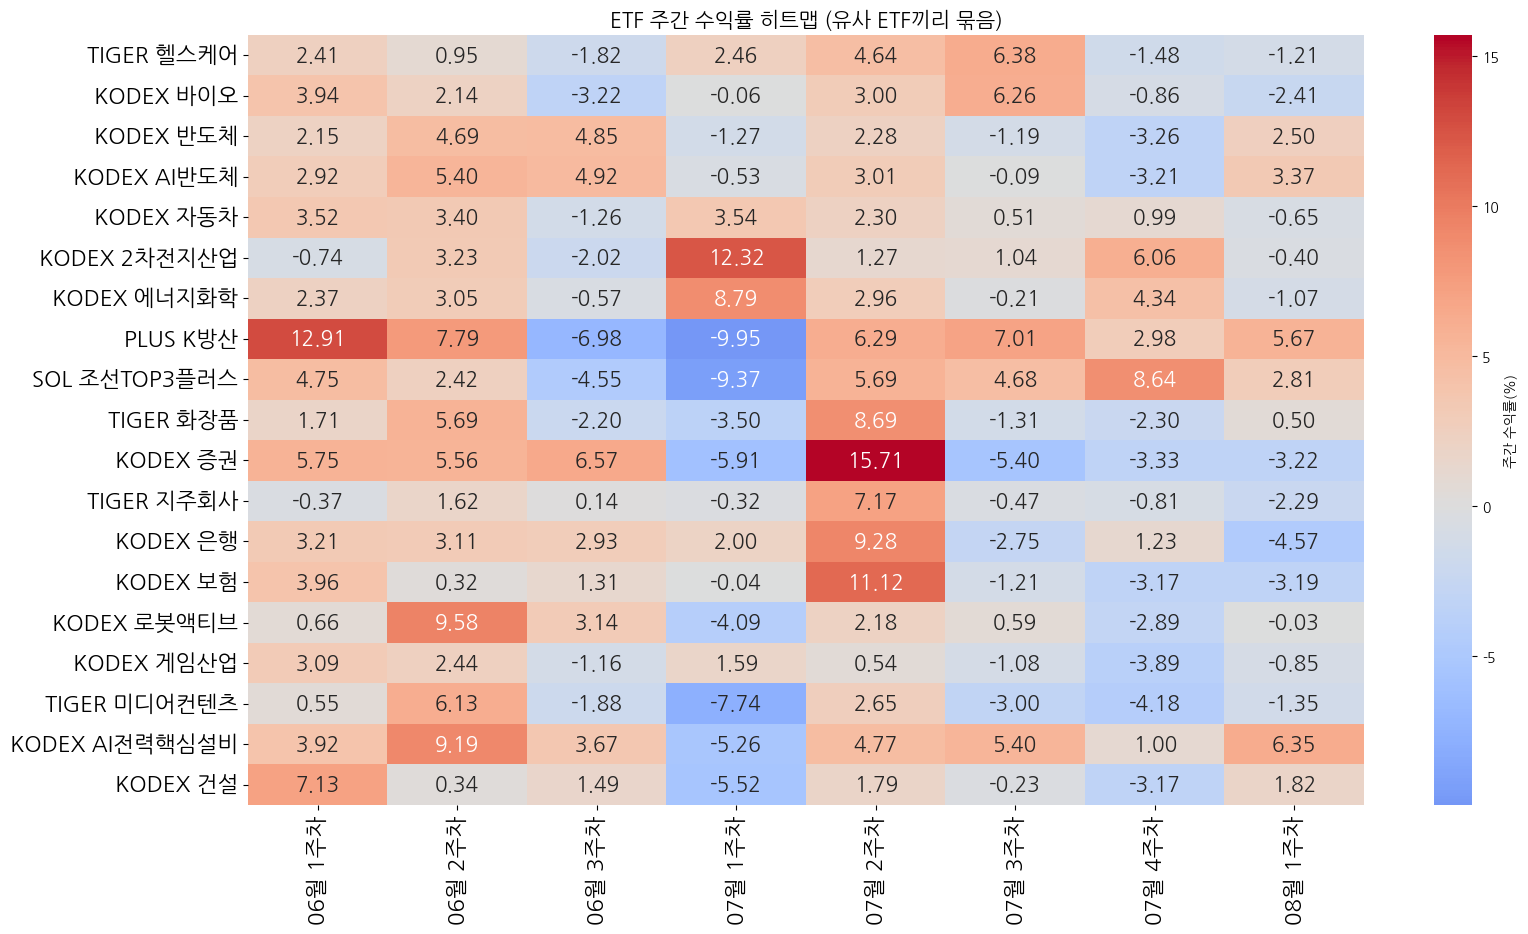

In [14]:
# ETF 가격 데이터에서 결측치 제거
selected_etf_price = etf_price[etf_lst].dropna()["2025-06":]
daily_rtn = selected_etf_price.pct_change().dropna()
weekly_price = selected_etf_price.resample('W-FRI').last()
weekly_return = weekly_price.pct_change().dropna() * 100

# 년월, 몇주차 형태의 인덱스 생성 함수
def make_year_month_week_index(dt_index):
    # dt_index: DatetimeIndex
    result = []
    prev_year = None
    prev_month = None
    week_num = 0
    for dt in dt_index:
        year = dt.year
        month = dt.month
        # 같은 년월이면 week_num +1, 아니면 1로 초기화
        if (year != prev_year) or (month != prev_month):
            week_num = 1
            prev_year = year
            prev_month = month
        else:
            week_num += 1
        result.append(f"{month:02d}월 {week_num}주차")
    return result

weekly_return = weekly_return.copy()
weekly_return.index = make_year_month_week_index(weekly_return.index)

# ETF별로 일간 수익률의 상관관계를 기반으로 클러스터링
corr = daily_rtn.corr()
linkage_matrix = linkage(corr, method='ward')
etf_order = leaves_list(linkage_matrix)
ordered_etf = [weekly_return.columns[i] for i in etf_order]

plt.figure(figsize=(18,10))
sns.heatmap(
    weekly_return[ordered_etf].T, 
    cmap="coolwarm", 
    center=0, 
    annot=True, 
    fmt=".2f",
    cbar_kws={'label': '주간 수익률(%)'},
    annot_kws={"size":15}, # 주석 폰트 크기 키움
    xticklabels=True,
    yticklabels=True
)
plt.title("ETF 주간 수익률 히트맵 (유사 ETF끼리 묶음)", fontsize=15)
plt.ylabel(None)
plt.xticks(fontsize=16, rotation=90)  # x축 레이블 90도 회전
plt.yticks(fontsize=16);